In [ ]:
!pip install shap==0.36.0
!pip install transformers==3.3.1
!pip install datasets

     |████████████████████████████████| 327kB 6.4MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp37-cp37m-linux_x86_64.whl size=457600 sha256=6a481250f0b994179a5f2e5a13f7e806344101d6b7cae64c0f2d6666f70a59bb
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap
     |████████████████████████████████| 1.1MB 4.9MB/s 
     |████████████████████████████████| 1.2MB 15.9MB/s 
     |████████████████████████████████| 3.0MB 22.8MB/s 
     |████████████████████████████████| 890kB 49.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=d3b592fa459c6f32ebf1f5c6eec04588a6c2cad9202b492492e3d7e0e0650bdf
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 184kB 6.6MB/s 
     |████████████████████████████████| 245kB 8.3MB/s 
     |██████████████████

In [ ]:
import shap
import umap
import transformers
import torch
import os
import time
import random
import datetime
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, pipeline
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel, pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (AnchoredOffsetbox, DrawingArea, HPacker,
                                  TextArea)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('drive/MyDrive/Colab Notebooks/nn_project')

Mounted at /content/drive


In [ ]:
# get labeled data
DATA_PATH = 'data/ynet_data.csv'
PICKLE_PATH = 'data/ynet_data.pkl'
DELIMITER = ';;;'
COLNAMES = ['date', 'title', 'sub-title', 'article', 'label',\
            'author', 'url', 'tag1', 'tag2', 'tag3', 'tag4', 'tag5', 'tag6']
# ynet_data = pd.read_csv(DATA_PATH, delimiter=DELIMITER, header=None, names=COLNAMES,\
#             error_bad_lines=False, warn_bad_lines=False, index_col=False)
ynet_data = pd.read_pickle(PICKLE_PATH)
label_dict = {key: value for value, key in enumerate(ynet_data.label.unique())}
ynet_data['label_num'] = ynet_data['label'].map(label_dict)
tagged_df = ynet_data[ynet_data['tag1'].notnull()]
article_df = ynet_data[ynet_data['article'].notnull()]

In [ ]:
ynet_data.head(2)

,index,date,title,sub-title,article,label,author,url,tag1,tag2,tag3,tag4,tag5,tag6,article_len,title_len,sub-title_len,label_num
67317,41330,201812,"צה""ל איתר ופוצץ מנהרת טרור חמישית של חיזבאללה","לוחמי צה""ל איתרו ונטרלו מנהרה נוספת אשר חצת...","דובר צה\""ל הודיע הערב (יום רביעי) כי לוחמי...",צבאי,"יואב זיתון, אחיה ראב\","http://www.ynet.co.il/articles/0,7340,L-543291...","צה""ל",מגן צפוני,חיזבאללה,גבול הצפון,גבול לבנון,מנהרות טרור,2173.0,45,151,0
121099,13975,200711,"אסף חפץ: ""עוד יהפכו את הבלשים לרובין הוד""","מפכ""ל המשטרה לשעבר מזהיר ממצב בו יהפכו השוט...","\""זהו סיפור קשה של חריגה מנורמות, אבל מאחר שהש...",משפט ופלילי,רועי מנדל,"http://www.ynet.co.il/articles/0,7340,L-347454...",NaN,NaN,NaN,NaN,NaN,NaN,2685.0,41,230,1


In [ ]:
ynet_data.describe()[['title_len', 'sub-title_len', 'article_len']]

,title_len,sub-title_len,article_len
count,265287.000000,265287.000000,263389.000000
mean,41.398289,168.334672,2056.676813
std,8.770490,67.849562,1602.727611
min,4.000000,3.000000,1.000000
25%,37.000000,126.000000,1161.000000
50%,40.000000,169.000000,1693.000000
75%,44.000000,212.000000,2527.000000
max,324.000000,596.000000,225512.000000


In [ ]:
titles = ynet_data.title.values
labels = ynet_data.label_num.values
num_classes = len(ynet_data['label_num'].unique())

In [ ]:
# HeBert tokenizer
tokenizer = transformers.BertTokenizerFast.from_pretrained("avichr/heBERT_sentiment_analysis")

# Print the original sentence.
print(' Original: ', titles[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(titles[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(titles[0])))



 Original:  צה"ל איתר ופוצץ מנהרת טרור חמישית של חיזבאללה
Tokenized:  ['צה', '"', 'ל', 'אית', '##ר', 'ופ', '##וצץ', 'מנה', '##רת', 'טרור', 'חמישית', 'של', 'חיזבאללה']
Token IDs:  [3276, 6, 207, 2502, 1017, 2240, 9449, 2280, 1609, 6037, 35023, 1495, 19842]


In [ ]:
MAX_LEN = 50 # This is for titles only, hebert can take up to 500

input_ids = []
attention_masks = []

"""
"use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or "
"use `padding='max_length'` to pad to a max length. In this case, you can give a specific "
"length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the "
"maximal input size of the model (e.g. 512 for Bert).",
"""

for title in titles:
    encoded_dict = tokenizer.encode_plus(
                        title,                          # Sentence to encode.
                        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',          # Return pytorch tensors.
                        truncation=True,                # This get rid of the annoying time consming message
                        padding = 'max_length',
                   )
                        # padding = 'longest',
    # Add the encoded title to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', titles[0])
print('Token IDs:', input_ids[0])

Original:  צה"ל איתר ופוצץ מנהרת טרור חמישית של חיזבאללה
Token IDs: tensor([    2,  3276,     6,   207,  2502,  1017,  2240,  9449,  2280,  1609,
         6037, 35023,  1495, 19842,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [ ]:

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
 
# batch size should be 16 or 32 (bert).
batch_size = 32
# batch_size = 192
# batch_size = 7

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

238,758 training samples
26,529 validation samples


In [ ]:
model = transformers.BertForSequenceClassification.\
        from_pretrained("avichr/heBERT_sentiment_analysis", num_labels=2).cuda()

params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 105 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (52000, 768)
bert.embeddings.position_embeddings.weight                (514, 768)
bert.embeddings.token_type_embeddings.weight                (1, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Replace classifier with a fresh one of the right size
INIT_RANGE = 0.1
model.num_labels = num_classes
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
_ = model.classifier.bias.data.zero_()
_ = model.classifier.weight.data.uniform_(-INIT_RANGE, INIT_RANGE)

In [ ]:
# define a prediction function
def predict(x):
    model.eval()
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True,\
                                    max_length=50, truncation=True, padding='max_length') for v in x]).cuda()
    with torch.no_grad():        
        activated = torch.softmax(model(tv)[0], dim=1)
    _, predictions = torch.max(activated, 1)
    return predictions

def get_latent(model, x):
    model.eval()
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True,\
                                    max_length=50, truncation=True, padding='max_length') for v in x]).cuda()
    with torch.no_grad():
        latent = model(tv)[0]
    mean_latent = torch.mean(latent, axis=0)
    return latent, mean_latent

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def get_val(model):
    # Measure performance on val
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
        loss = result.loss
        logits = result.logits
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    return avg_val_loss, avg_val_accuracy, validation_time

In [ ]:
# bert paper reccomends lr of either 5e-5, 3e-5, 2e-5
# also reccomends either 2,3 or 4 epochs with batch size 16 or 32

EPOCHS = 4

optimizer = AdamW(model.parameters(),
                  lr = 3e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# To empty cuda cache and run garbage collector
torch.cuda.empty_cache()
import gc
# del variables
gc.collect()

251

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42
device = torch.device("cuda")

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

model = model.cuda()

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, EPOCHS):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    
    avg_val_loss, avg_val_accuracy, validation_time = get_val(model)
    
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        # WHERE IS THE CRITERION HERE? (BINARY CROSS ENTROPY?)
        # LOSS SHOULD BE COMPUTED VIA A CRITERRION FUNCTION SUCH AS:
                # criterion = nn.CrossEntropyLoss()
                # loss = criterion(output.view(-1, ntokens), targets)
        loss = result.loss
        logits = result.logits
        total_train_loss += loss.item()

        loss.backward() # calculate gradients

        # Clip the norm of the gradients to 1.0. (normaliziation)
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    avg_val_loss, avg_val_accuracy, validation_time = get_val(model)

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

Running Validation...
  Accuracy: 0.09
  Validation Loss: 2.60
  Validation took: 0:00:12
  Batch    40  of  7,462.    Elapsed: 0:00:15.
  Batch    80  of  7,462.    Elapsed: 0:00:17.
  Batch   120  of  7,462.    Elapsed: 0:00:20.
  Batch   160  of  7,462.    Elapsed: 0:00:22.
  Batch   200  of  7,462.    Elapsed: 0:00:24.
  Batch   240  of  7,462.    Elapsed: 0:00:27.
  Batch   280  of  7,462.    Elapsed: 0:00:29.
  Batch   320  of  7,462.    Elapsed: 0:00:32.
  Batch   360  of  7,462.    Elapsed: 0:00:34.
  Batch   400  of  7,462.    Elapsed: 0:00:37.
  Batch   440  of  7,462.    Elapsed: 0:00:39.
  Batch   480  of  7,462.    Elapsed: 0:00:41.
  Batch   520  of  7,462.    Elapsed: 0:00:44.
  Batch   560  of  7,462.    Elapsed: 0:00:46.
  Batch   600  of  7,462.    Elapsed: 0:00:49.
  Batch   640  of  7,462.    Elapsed: 0:00:51.
  Batch   680  of  7,462.    Elapsed: 0:00:54.
  Batch   720  of  7,462.    Elapsed: 0:00:56.
  Batch   760  of  7

In [ ]:
# with open('classifier.pkl', 'wb') as f:
#     torch.save(model, f)
model = torch.load('classifier.pkl')

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

def get_latent(model, x):
    model.eval()
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True,\
                                    max_length=50, truncation=True, padding='max_length') for v in x]).cuda()
    with torch.no_grad():
        latent = model(tv)[0]
    mean_latent = torch.mean(latent, axis=0)
    last_latent = latent[-1]
    return latent, mean_latent 

def add_point(scat, new_point, c='k'):
    old_off = scat.get_offsets()
    new_off = np.concatenate([old_off,np.array(new_point, ndmin=2)])
    old_c = scat.get_facecolors()
    new_c = np.concatenate([old_c, np.array(matplotlib.colors.to_rgba(c), ndmin=2)])

    scat.set_offsets(new_off)
    scat.set_facecolors(new_c)

    scat.axes.figure.canvas.draw_idle()
    

In [ ]:
latent_model = model
latent_model.classifier = Identity()

In [ ]:
latent_list = []
mean_latent_list = []

for title in titles:
    latent, mean_latent = get_latent(latent_model, [title])
    latent_list.append(latent)
    # mean_latent_list.append(mean_latent)

latent_array = np.array([tensor.cpu().numpy()[0] for tensor in latent_list])

In [ ]:
reducer = umap.UMAP()

scaler = StandardScaler().partial_fit(latent_array)
scaled_data = scaler.transform(latent_array)
# scaled_data = StandardScaler().fit_transform(latent_array)
embedding = reducer.fit_transform(scaled_data)

Graph is not fully connected, spectral embedding may not work as expected.
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!


In [ ]:
# with open('data/latent.pkl', 'wb') as file:
#     pickle.dump([latent_list, mean_latent_list], file)

# with open('data/latent.pkl', 'rb') as file:
#     latent_list, _ = pickle.load(file)

# latent_array = np.array([tensor.cpu().numpy()[0] for tensor in latent_list])

with open('data/embedding.pkl', 'wb') as file:
    pickle.dump(embedding, file)

# with open('data/embedding.pkl', 'rb') as file:
#     embedding = pickle.load(file)

In [ ]:
test_title = """ליצמן"""
latent, mean_latent = get_latent(latent_model, [test_title])

test_latent_array = latent.cpu().numpy()[0]

scaled = scaler.transform([test_latent_array])
embedded = reducer.transform(scaled)

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [ ]:
test_title = """ליצמן"""
latent, mean_latent = get_latent(latent_model, [test_title])

test_latent_array = latent.cpu().numpy()[0]

scaled = scaler.transform([test_latent_array])
embedded = reducer.transform(scaled)

In [ ]:
test_titles = \
            [
             """בנימין נתניהו""",
             """פנדל""",
             """ליצמן""",
             """גבי אשכנזי""",
             """משה קצב""",
             """רון חולדאי""",
             """פנינה רוזנבלום""",
             """תקציב משרד הביטחון"""
            ]
embedded_list = []
for title in test_titles:
    latent, mean_latent = get_latent(latent_model, [title])
    
    scaled = scaler.transform([latent.cpu().numpy()[0]])
    embedded = reducer.transform(scaled)
    embedded_list.append((title, embedded))

In [ ]:
plt.savefig('test.png')

<Figure size 432x288 with 0 Axes>

Creating legend with loc="best" can be slow with large amounts of data.
Creating legend with loc="best" can be slow with large amounts of data.
Creating legend with loc="best" can be slow with large amounts of data.
Creating legend with loc="best" can be slow with large amounts of data.


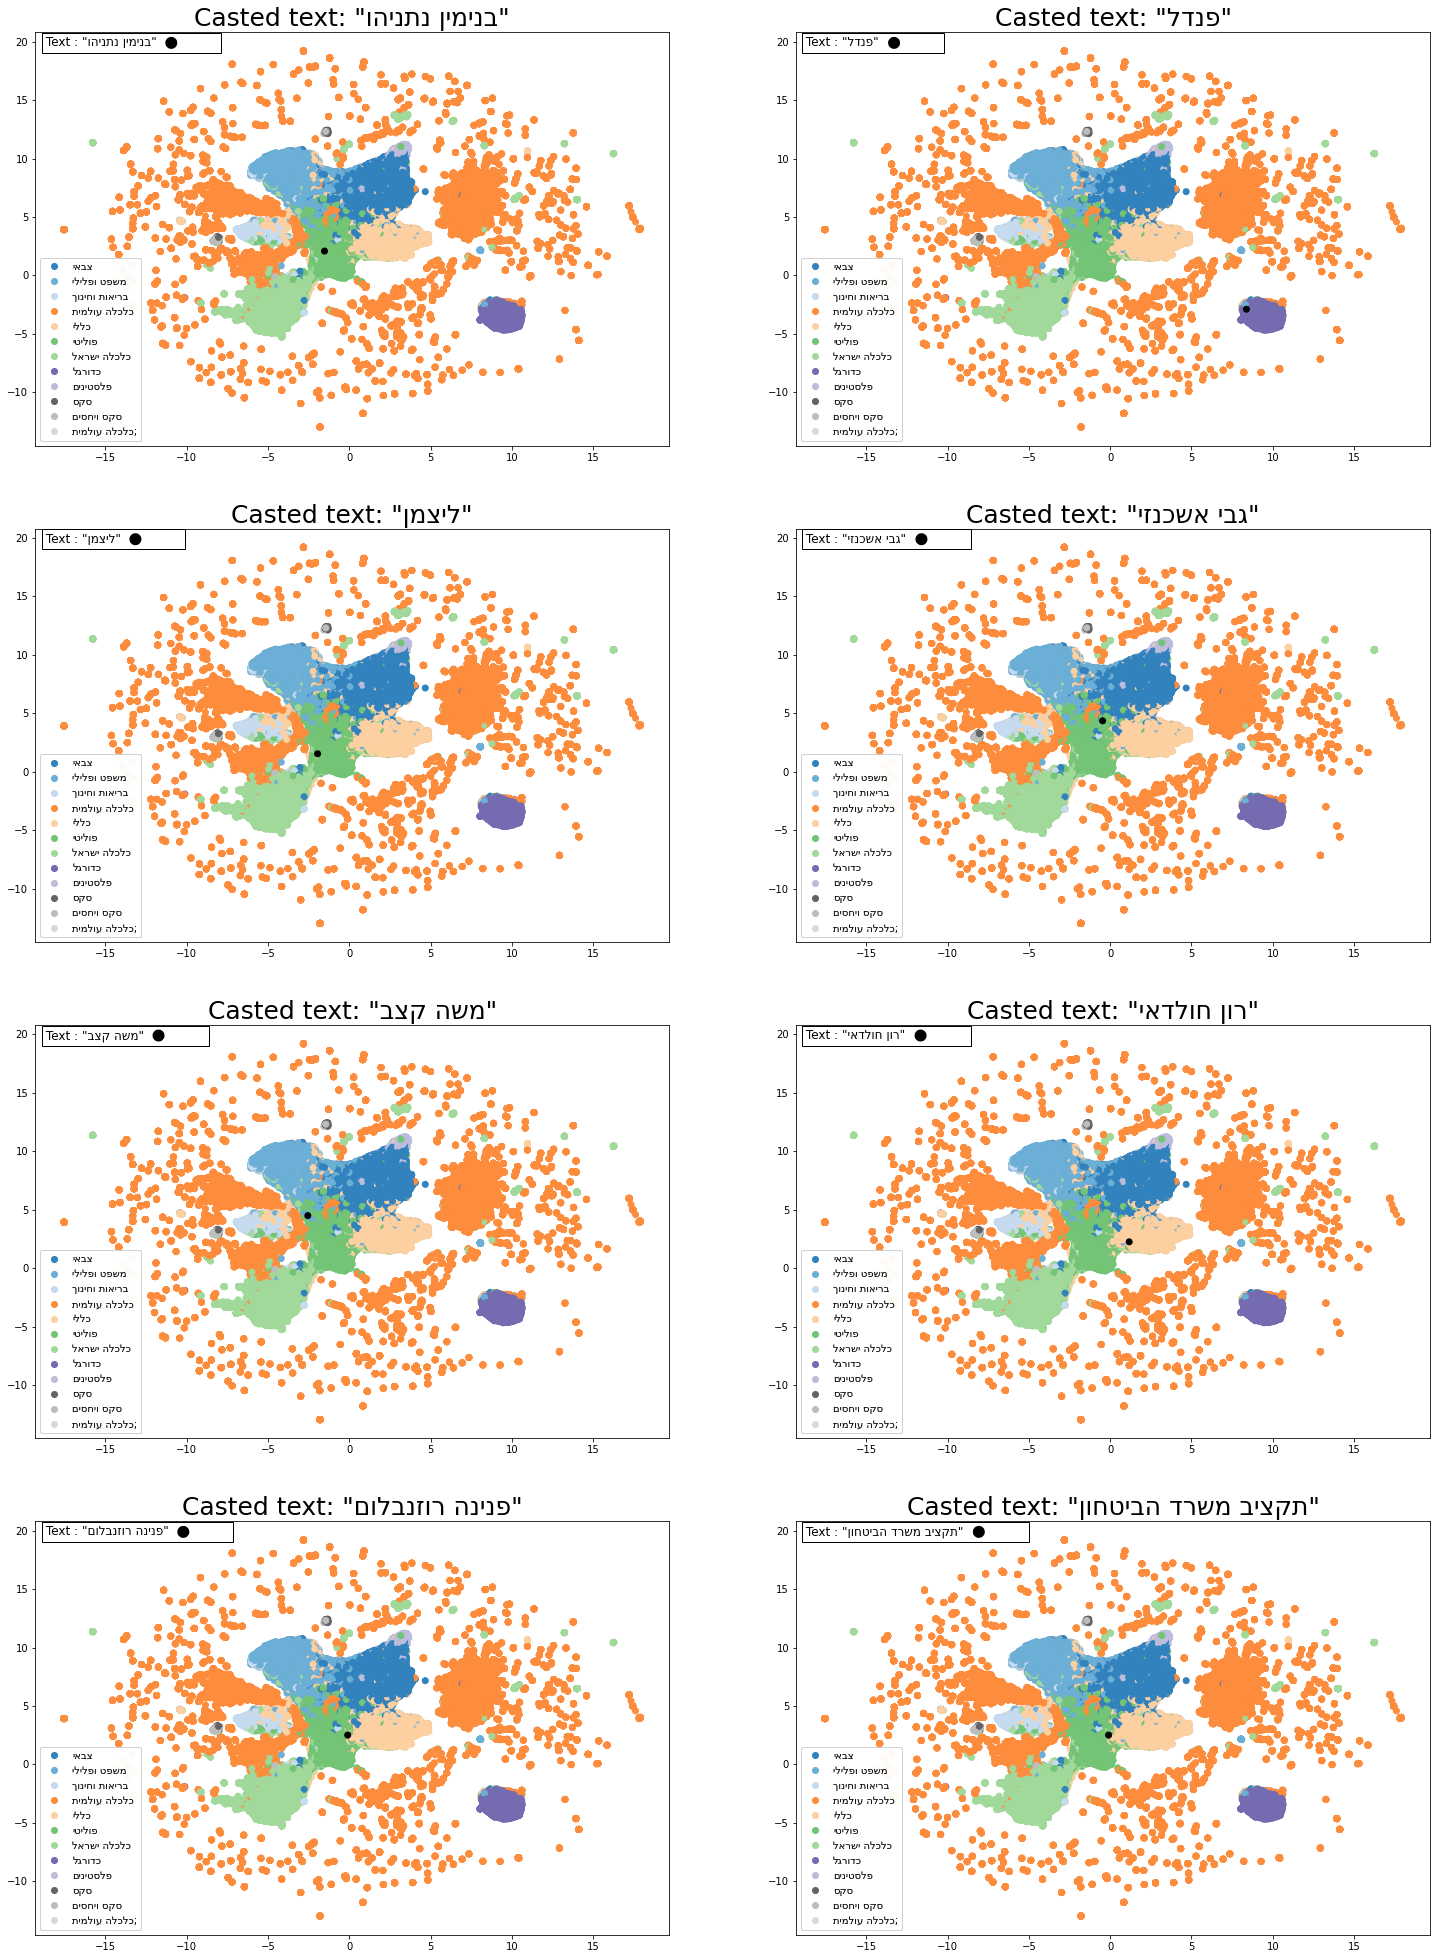

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(25, 35))
c = [[c for c in range(1,13)][x] for x in ynet_data.label\
       .map({label: i for i, label in enumerate(ynet_data.label.unique())})]

for i, (title, casted) in enumerate(embedded_list):
    scatter = axes[i//2][i%2].scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=c,
        cmap='tab20c'
                )

    legend1 = axes[i//2][i%2].legend(scatter.legend_elements()[0],\
                        [text[::-1] for text in ynet_data.label.unique()],\
                        fontsize=12, prop={'size': 10})

    box1 = TextArea(' Text : "{0}"'.format(title[::-1]),\
                    textprops=dict(color="k", fontsize=12))

    box2 = DrawingArea(60, 20, 0, 0)
    el1 = Ellipse((10, 10), width=12, height=12, angle=30, fc="black")
    box2.add_artist(el1)
    box = HPacker(children=[box1, box2],
                align="center",
                pad=0, sep=5)
    anchored_box = AnchoredOffsetbox(loc='lower left',
                                    child=box, pad=0.,
                                    frameon=True,
                                    bbox_to_anchor=(0.01, 0.95),
                                    bbox_transform=axes[i//2][i%2].transAxes,
                                    borderpad=0.,
                                    )
    axes[i//2][i%2].add_artist(anchored_box)
    axes[i//2][i%2].add_artist(legend1)
    fig.canvas.draw()
    add_point(scatter, casted, 'black')
    axes[i//2][i%2].set_title('Casted text: "{0}"'.format(title[::-1]), fontsize=25)
    
plt.savefig('test.png')

Creating legend with loc="best" can be slow with large amounts of data.
Creating legend with loc="best" can be slow with large amounts of data.


Text(0.5, 1.0, 'Casted text: "ןמציל בקעי"')

Creating legend with loc="best" can be slow with large amounts of data.
Creating legend with loc="best" can be slow with large amounts of data.


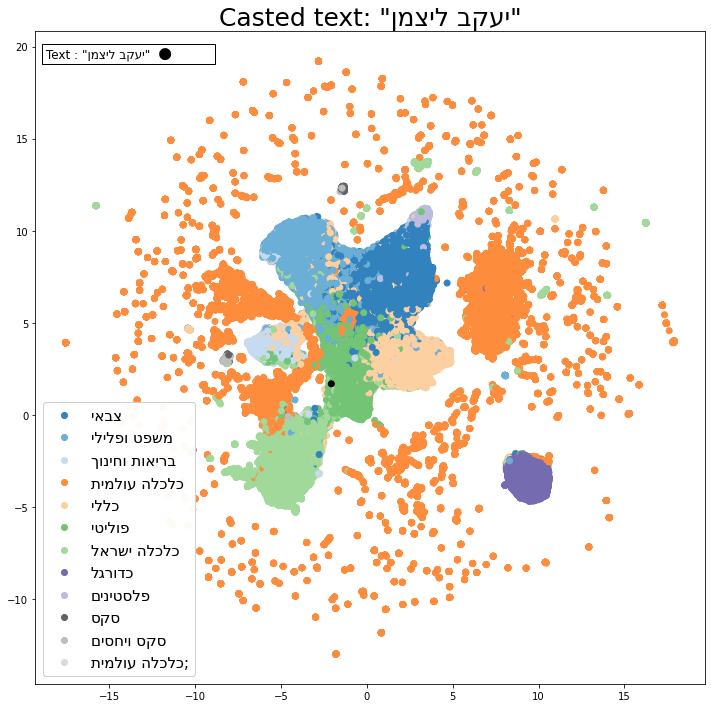

In [ ]:
test_title = """יעקב ליצמן"""
latent, mean_latent = get_latent(latent_model, [test_title])

test_latent_array = latent.cpu().numpy()[0]

scaled = scaler.transform([test_latent_array])
embedded = reducer.transform(scaled)

#####

fig, axes = plt.subplots(1, 1, figsize=(12, 12))
c = [[c for c in range(1,13)][x] for x in ynet_data.label\
       .map({label: i for i, label in enumerate(ynet_data.label.unique())})]

scatter = axes.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=c,
    cmap='tab20c'
            )

legend1 = axes.legend(scatter.legend_elements()[0],\
                      [text[::-1] for text in ynet_data.label.unique()],\
                      fontsize=12, prop={'size': 15})

box1 = TextArea(' Text : "{0}"'.format(test_title[::-1]),\
                textprops=dict(color="k", fontsize=12))
box2 = DrawingArea(60, 20, 0, 0)
el1 = Ellipse((10, 10), width=12, height=12, angle=30, fc="black")
box2.add_artist(el1)
box = HPacker(children=[box1, box2],
              align="center",
              pad=0, sep=5)
anchored_box = AnchoredOffsetbox(loc='lower left',
                                 child=box, pad=0.,
                                 frameon=True,
                                 bbox_to_anchor=(0.01, 0.95),
                                 bbox_transform=axes.transAxes,
                                 borderpad=0.,
                                 )
axes.add_artist(anchored_box)

axes.add_artist(legend1)

fig.canvas.draw()
add_point(scatter, embedded, 'black')

axes.set_title('Casted text: "{0}"'.format(test_title[::-1]), fontsize=25)

AttributeError: ignored

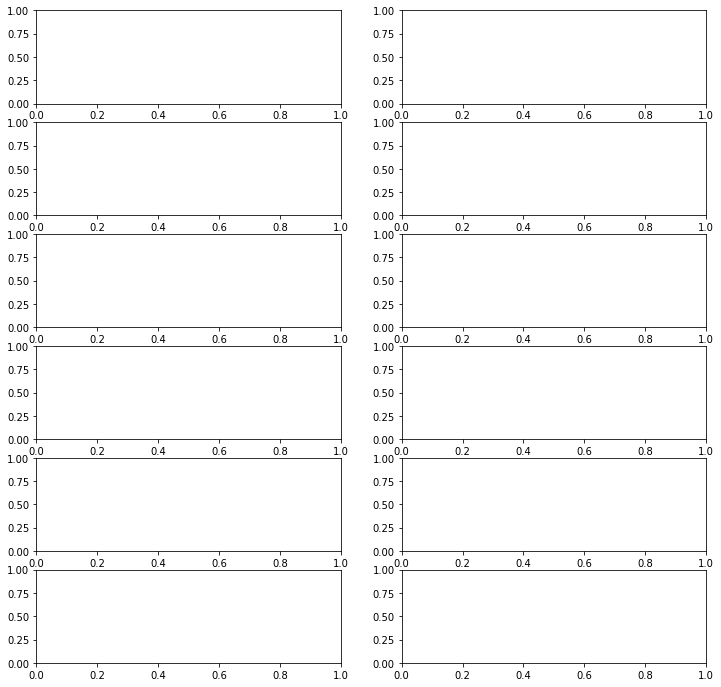

In [ ]:
# %%time
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
c = [[c for c in range(1,13)][x] for x in ynet_data.label\
       .map({label: i for i, label in enumerate(ynet_data.label.unique())})]

for i in enumerate()
scatter = axes.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=c,
    cmap='tab20c'
            )

# legend1 = axes.legend(scatter.legend_elements()[0],\
#                       [text[::-1] for text in ynet_data.label.unique()],\
#                       fontsize=12, prop={'size': 15})

# box1 = TextArea(' Text : "{0}"'.format(test_title[::-1]),\
#                 textprops=dict(color="k", fontsize=12))
# box2 = DrawingArea(60, 20, 0, 0)
# el1 = Ellipse((10, 10), width=12, height=12, angle=30, fc="black")
# box2.add_artist(el1)
# box = HPacker(children=[box1, box2],
#               align="center",
#               pad=0, sep=5)
# anchored_box = AnchoredOffsetbox(loc='lower left',
#                                  child=box, pad=0.,
#                                  frameon=True,
#                                  bbox_to_anchor=(0.01, 0.95),
#                                  bbox_transform=axes.transAxes,
#                                  borderpad=0.,
#                                  )
# axes.add_artist(anchored_box)

# axes.add_artist(legend1)

# fig.canvas.draw()
# add_point(scatter, embedded, 'black')

# axes.set_title('Casted text: "{0}"'.format(test_title[::-1]), fontsize=25)

In [ ]:
NUM_TEST = 9

test_titles = \
        [
        """מכבי תל אביב ניצחה בגביע המדינה לכדורגל""", 
        """צה"ל תקף בסוריה""",
        """נבחרת הכדורגל של צה"ל""",
        """ביבי""",
        """ליצמן""",
        """טיפים לחיי מין טובים יותר""",
        """נבחרת הכדורגל הפלסטינית""",
        """רופאים ממליצים לשחק כדורגל""",
        """רופא בכיר נחקר במשטרה"""
        ]

test_latent_list = []

for title in test_titles:
    latent, mean_latent = get_latent(latent_model, [title])
    test_latent_list.append(latent)

test_latent_array = np.array([tensor.cpu().numpy()[0] for tensor in test_latent_list])

to_scale = np.vstack((latent_array, test_latent_array))

scaled_data = StandardScaler().fit_transform(to_scale)
embedding = reducer.fit_transform(scaled_data)

In [ ]:
reducer = umap.UMAP()
scaled_data = StandardScaler().fit_transform(latent_array)
embedding = reducer.fit_transform(latent_array)

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!


Creating legend with loc="best" can be slow with large amounts of data.


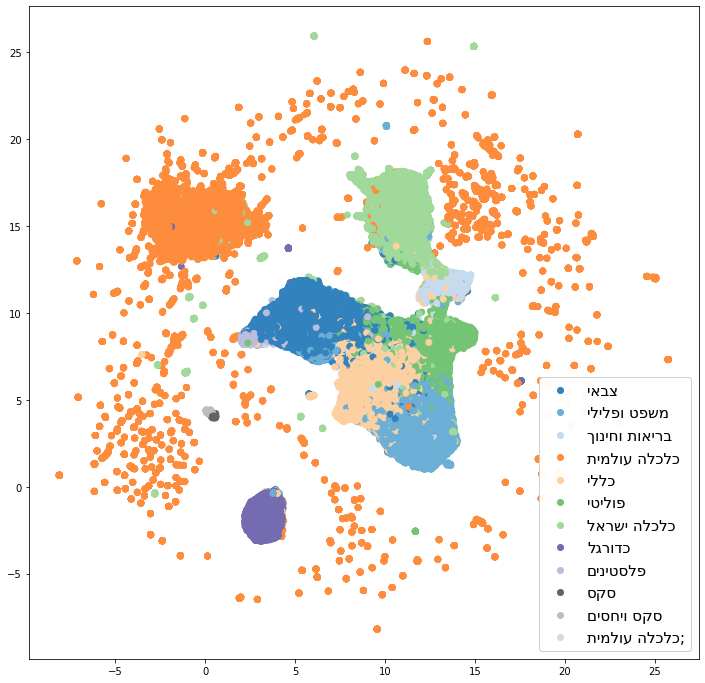

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(12, 12))

scatter = axes.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[[c for c in range(1,13)][x] for x in ynet_data.label\
       .map({label: i for i, label in enumerate(ynet_data.label.unique())})],
    cmap='tab20c'
            )

# cmap='YlGnBu'

legend1 = axes.legend(scatter.legend_elements()[0],\
                      [text[::-1] for text in ynet_data.label.unique()],\
                      fontsize=12, prop={'size': 15})
axes.add_artist(legend1)

In [ ]:
label_dict

{';כלכלה עולמית': 11,
 'בריאות וחינוך': 2,
 'כדורגל': 7,
 'כלכלה ישראל': 6,
 'כלכלה עולמית': 3,
 'כללי': 4,
 'משפט ופלילי': 1,
 'סקס': 9,
 'סקס ויחסים': 10,
 'פוליטי': 5,
 'פלסטינים': 8,
 'צבאי': 0}

***Incorrect classifications***


In [ ]:
i = 4
print('title')
print(titles[0:500][predict(titles[0:500]).cpu() != labels[0:500].cpu()][i])
print('prediction')
print(predict(titles[0:500])[predict(titles[0:500]).cpu() != labels[0:500].cpu()][i])
print('correct label')
print(labels[0:500][predict(titles[0:500]).cpu() != labels[0:500].cpu()][i])

In [ ]:
# distribution of wrong classifications - wrong predictions (what did we predict)
predicted_worng = predict(titles[0:5000])[predict(titles[0:5000]) != labels[0:5000]]

# distribution of wrong classifications - wrong labels (what we tried to find)
# predict(titles)[predict(titles).cpu() != labels.cpu()]
should_have = labels[0:5000][predict(titles[0:5000]) != labels[0:5000]]

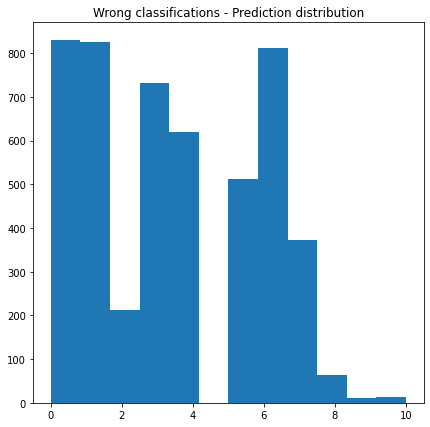

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
axes.set_title('Wrong classifications - Prediction distribution')
_ = axes.hist(predicted_worng.cpu(), bins=12)

# _ = axes.set_xlabel('epoch')
# _ = axes.set_ylabel('loss')

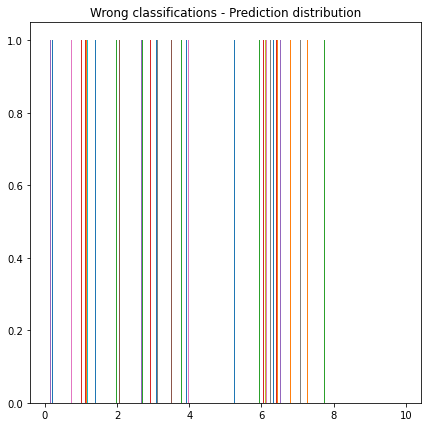

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
axes.set_title('Wrong classifications - Prediction distribution')
_ = axes.hist(should_have, bins=12)

# _ = axes.set_xlabel('epoch')
# _ = axes.set_ylabel('loss')